FPL TEAM PLAYSTYLE ANALYSIS - AUTO-UPDATING
Gameweek detection: Found 5 completed gameweeks
Fetching FPL data for team analysis...
Data fetch time: 2025-09-24 19:32:49
Calculating team metrics based on 5 gameweeks...
Team metrics validation:
xG per game range: 0.75 to 2.02
xGA per game range: 5.70 to 22.39
Calculating player offensive metrics with auto-filtering...
Player filtering applied:
  Criteria: 45+ avg mins/GW, 2+ starts, 180+ total mins
  Original players: 741
  After filtering: 203
  Removed: 538 players with insufficient minutes
Examples of filtered players:
  Arrizabalaga (Arsenal): 0 mins (0.0/GW), 0 starts
  Hein (Arsenal): 0 mins (0.0/GW), 0 starts
  Setford (Arsenal): 0 mins (0.0/GW), 0 starts
Final consistent player count: 203
Player metrics validation:
Player xG per 90 range: 0.000 to 1.347
Data loaded: 20 teams, 203 consistent players

AUTO-UPDATED Team Metrics (based on 5 gameweeks):
------------------------------------------------------------
          name  xga_pe

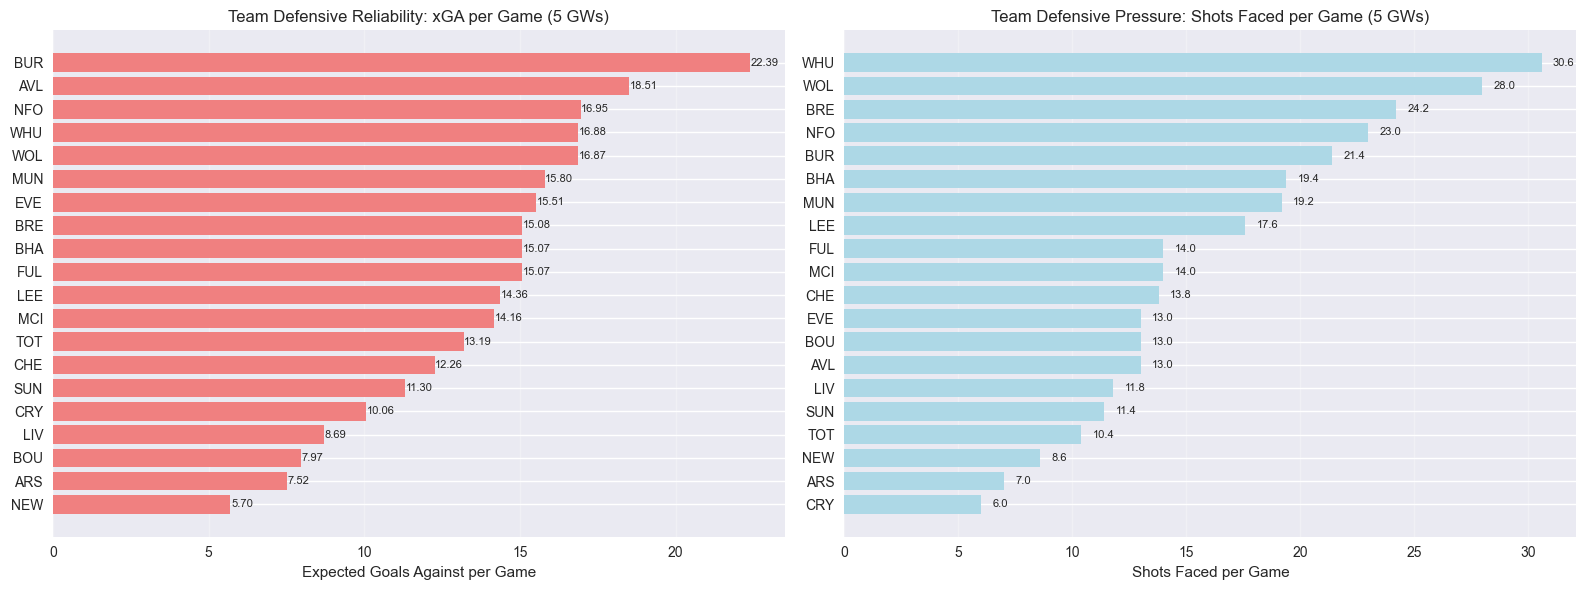


Creating Team Offensive Reliability visualization...


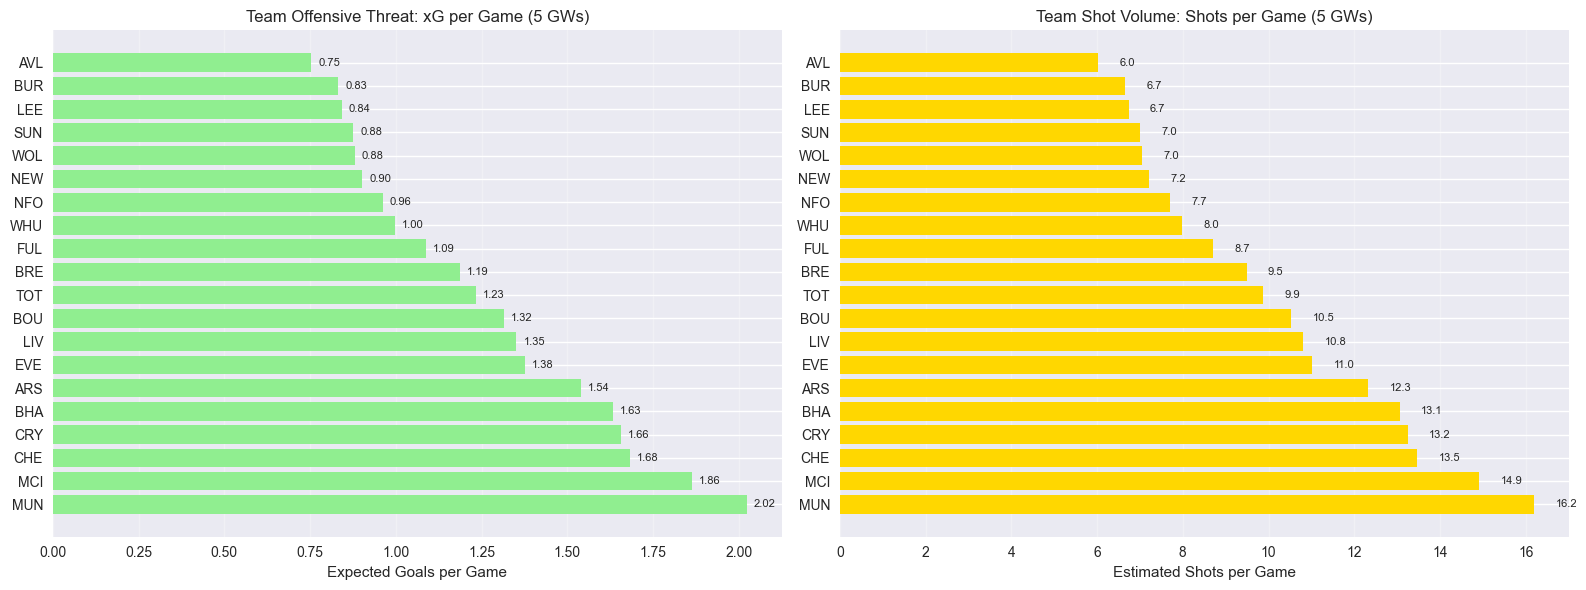


Creating Team Efficiency Analysis...


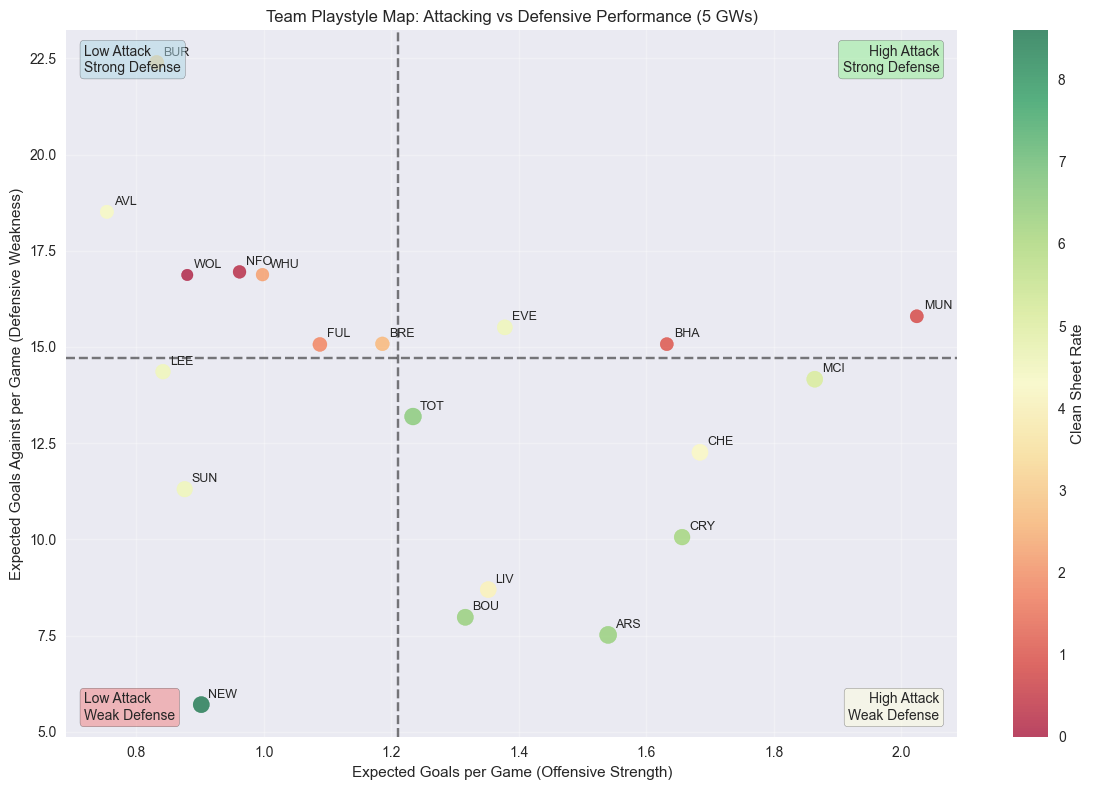


Creating Player Offensive Analysis (Consistent Players Only)...


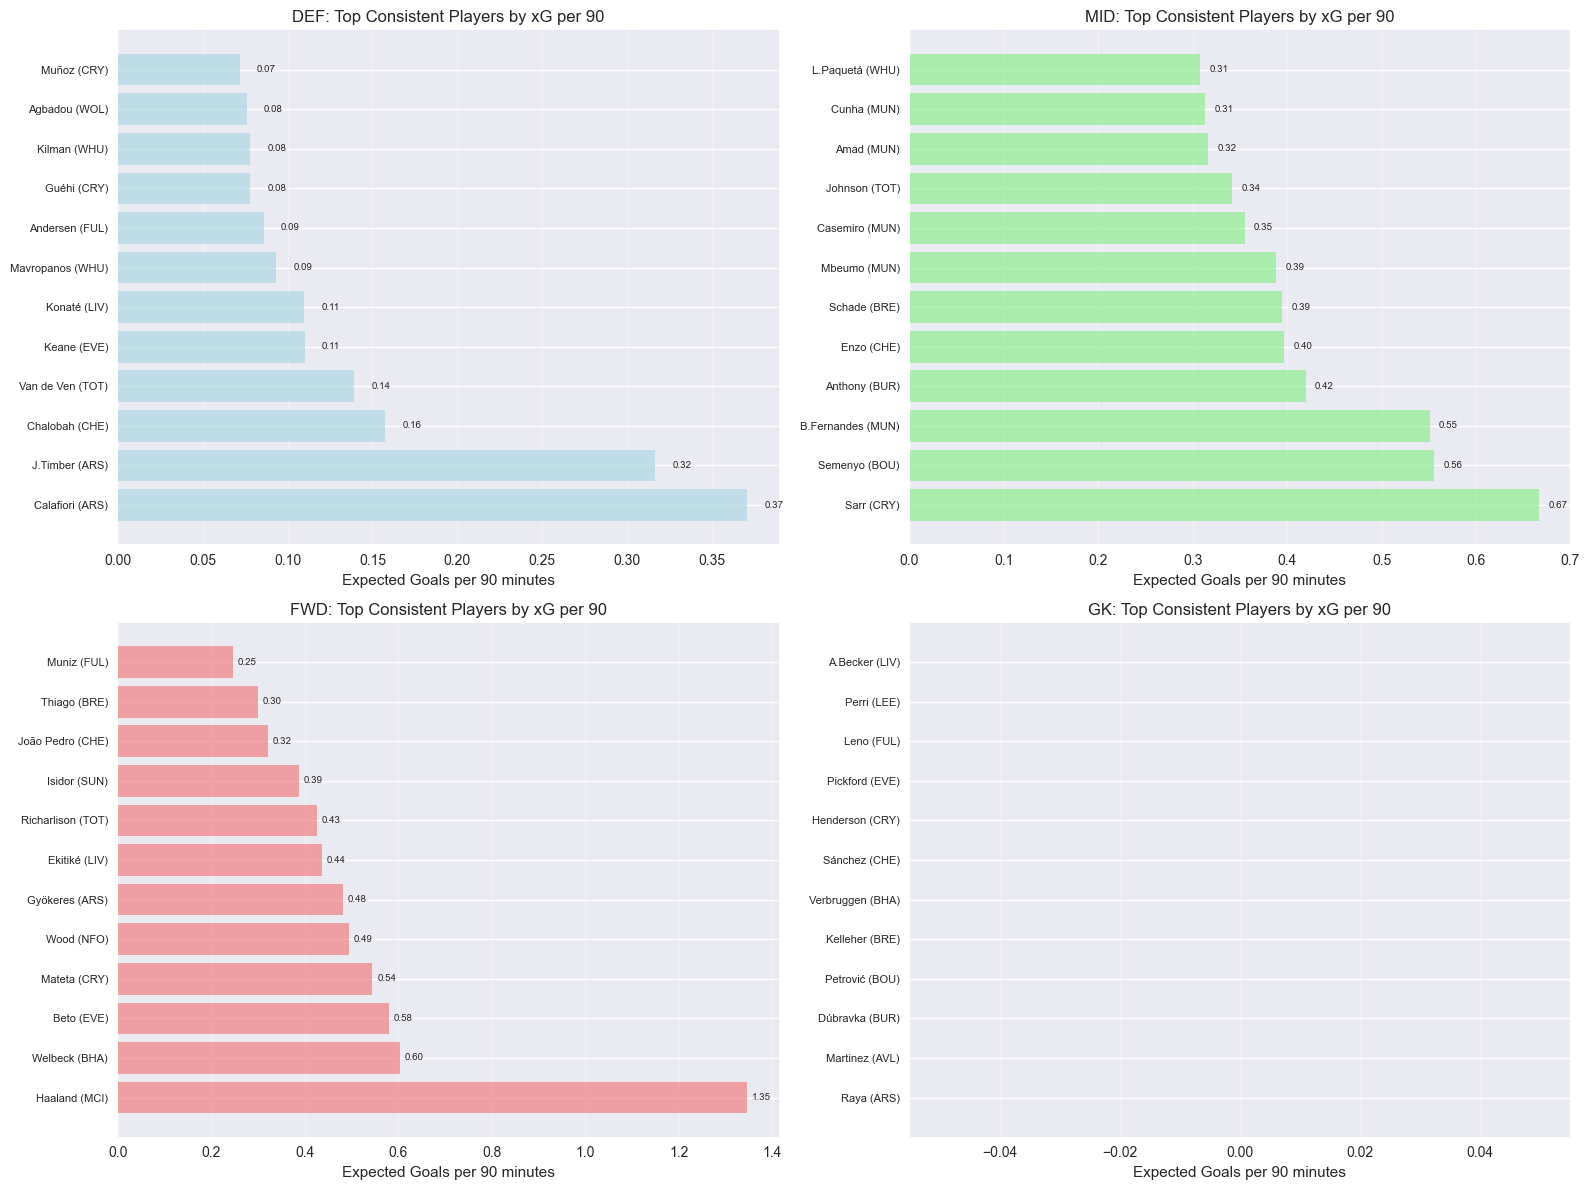


Creating Interactive Team Comparison...


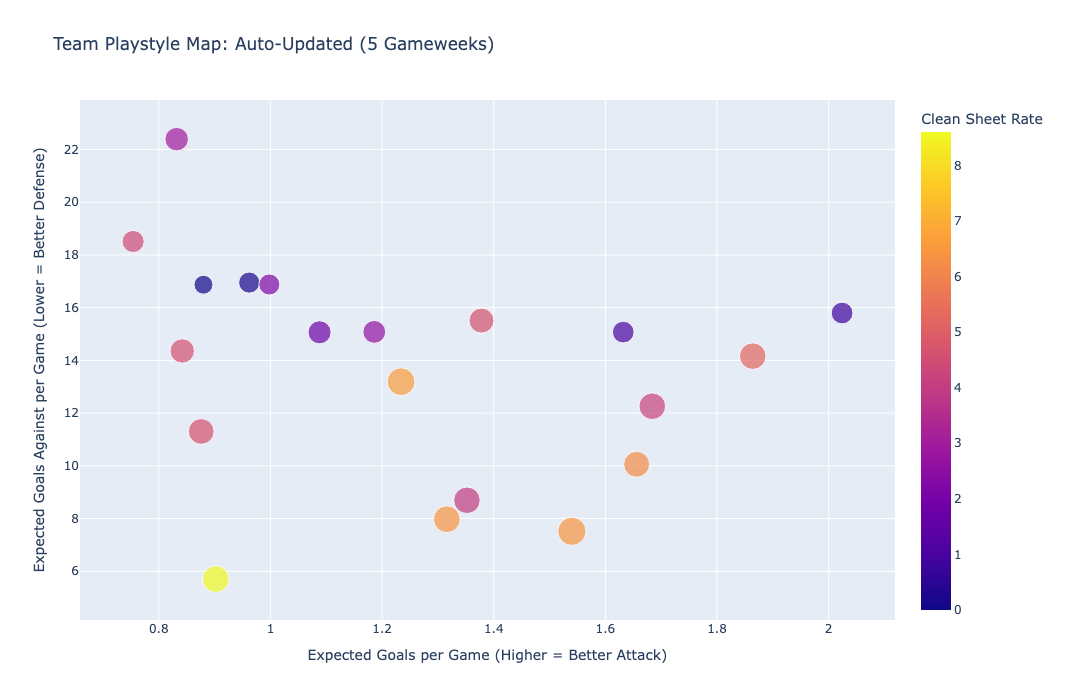


TEAM PLAYSTYLE SUMMARY - AUTO-UPDATED (5 GWs)

MOST DEFENSIVELY RELIABLE TEAMS:
Newcastle: 5.70 xGA/game, 8.6 shots faced/game, 860% CS rate
Arsenal: 7.52 xGA/game, 7.0 shots faced/game, 640% CS rate
Bournemouth: 7.97 xGA/game, 13.0 shots faced/game, 640% CS rate
Liverpool: 8.69 xGA/game, 11.8 shots faced/game, 400% CS rate
Crystal Palace: 10.06 xGA/game, 6.0 shots faced/game, 620% CS rate

MOST OFFENSIVELY RELIABLE TEAMS:
Man Utd: 2.02 xG/game, 16.2 shots/game, 0.80 goals/game
Man City: 1.86 xG/game, 14.9 shots/game, 1.80 goals/game
Chelsea: 1.68 xG/game, 13.5 shots/game, 2.00 goals/game
Crystal Palace: 1.66 xG/game, 13.2 shots/game, 1.20 goals/game
Brighton: 1.63 xG/game, 13.1 shots/game, 1.20 goals/game

MOST EFFICIENT TEAMS (Goals vs xG):
Liverpool: +0.85 efficiency (2.20 goals vs 1.35 xG)
Spurs: +0.57 efficiency (1.80 goals vs 1.23 xG)
Arsenal: +0.46 efficiency (2.00 goals vs 1.54 xG)
Sunderland: +0.32 efficiency (1.20 goals vs 0.88 xG)
Chelsea: +0.32 efficiency (2.00 goals vs 1.

In [5]:
# FPL Team & Player Playstyle Analysis - Auto-Updating Version
# Analyzing defensive and offensive reliability through xG metrics and shot data

import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class TeamPlaystyleAnalyzer:
    """
    Analyze team and player playstyles focusing on:
    - Defensive reliability: xGA per 90, shots faced per 90
    - Offensive reliability: xG per 90, shots per 90
    """
    
    def __init__(self):
        self.base_url = "https://fantasy.premierleague.com/api/"
    
    def detect_gameweeks_played(self):
        """Automatically detect how many gameweeks have been played."""
        try:
            response = requests.get(f"{self.base_url}bootstrap-static/")
            data = response.json()
            gameweeks_df = pd.DataFrame(data['events'])
            
            # Convert to proper types
            gameweeks_df['finished'] = gameweeks_df['finished'].astype(bool)
            gameweeks_df['is_current'] = gameweeks_df['is_current'].astype(bool)
            
            # Method 1: Count finished gameweeks
            finished_gws = gameweeks_df[gameweeks_df['finished'] == True]
            if not finished_gws.empty:
                gameweeks_played = len(finished_gws)
                print(f"Gameweek detection: Found {gameweeks_played} completed gameweeks")
                return gameweeks_played
            
            # Method 2: Find current gameweek and assume previous are finished
            current_gw = gameweeks_df[gameweeks_df['is_current'] == True]
            if not current_gw.empty:
                current_gw_num = int(current_gw.iloc[0]['id'])
                # If current GW has started, previous ones are likely finished
                gameweeks_played = max(1, current_gw_num - 1)
                print(f"Gameweek detection: Current GW{current_gw_num}, assuming {gameweeks_played} completed")
                return gameweeks_played
            
            # Method 3: Use reasonable estimate
            gameweeks_played = 5  # Conservative estimate for mid-season
            print(f"Gameweek detection: Using fallback estimate of {gameweeks_played}")
            return gameweeks_played
            
        except Exception as e:
            print(f"Error detecting gameweeks: {e}")
            print("Using default: 5 gameweeks")
            return 5
        
    def fetch_data(self):
        """Fetch comprehensive data for team and player analysis."""
        print("Fetching FPL data for team analysis...")
        print(f"Data fetch time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        
        # Get bootstrap data
        response = requests.get(f"{self.base_url}bootstrap-static/")
        data = response.json()
        
        # Process data
        players_df = pd.DataFrame(data['elements'])
        teams_df = pd.DataFrame(data['teams'])
        
        # Position mapping
        position_mapping = {1: 'GK', 2: 'DEF', 3: 'MID', 4: 'FWD'}
        
        # Merge team data with players
        players_df = players_df.merge(
            teams_df[['id', 'name', 'short_name']], 
            left_on='team', right_on='id', suffixes=('', '_team')
        )
        
        players_df['position'] = players_df['element_type'].map(position_mapping)
        players_df['price'] = players_df['now_cost'] / 10.0
        players_df['team_name'] = players_df['name']
        
        # Convert numeric columns
        numeric_cols = [
            'minutes', 'goals_scored', 'assists', 'clean_sheets', 'goals_conceded',
            'saves', 'bonus', 'bps', 'influence', 'creativity', 'threat', 
            'expected_goals', 'expected_assists', 'expected_goals_conceded',
            'total_points', 'starts'
        ]
        
        for col in numeric_cols:
            if col in players_df.columns:
                players_df[col] = pd.to_numeric(players_df[col], errors='coerce').fillna(0)
        
        return players_df, teams_df
        
    def calculate_team_metrics(self, players_df, teams_df, gameweeks_played):
        """Calculate team-level offensive and defensive metrics - AUTO-UPDATING VERSION."""
        print(f"Calculating team metrics based on {gameweeks_played} gameweeks...")
        
        # Calculate team aggregated stats
        team_stats = players_df.groupby('team').agg({
            'expected_goals': 'sum',
            'expected_goals_conceded': 'sum',
            'goals_scored': 'sum',
            'goals_conceded': 'sum',
            'saves': 'sum',
            'clean_sheets': 'sum',
            'assists': 'sum',
            'total_points': 'sum'
        }).reset_index()
        
        # Merge with team info
        team_analysis = team_stats.merge(
            teams_df[['id', 'name', 'short_name']], 
            left_on='team', right_on='id'
        )
        
        # CORRECTED CALCULATION: per-game metrics using auto-detected gameweeks
        team_analysis['xg_per_90'] = team_analysis['expected_goals'] / gameweeks_played
        team_analysis['xga_per_90'] = team_analysis['expected_goals_conceded'] / gameweeks_played
        team_analysis['goals_per_90'] = team_analysis['goals_scored'] / gameweeks_played
        team_analysis['goals_conceded_per_90'] = team_analysis['goals_conceded'] / gameweeks_played
        
        # Estimate shots faced using saves + goals conceded (approximation)
        team_analysis['estimated_shots_faced'] = team_analysis['saves'] + team_analysis['goals_conceded']
        team_analysis['shots_faced_per_90'] = team_analysis['estimated_shots_faced'] / gameweeks_played
        
        # Estimate shots taken using xG (typically xG correlates with shots)
        team_analysis['estimated_shots'] = team_analysis['expected_goals'] * 8
        team_analysis['shots_per_90'] = team_analysis['estimated_shots'] / gameweeks_played
        
        # Additional team metrics
        team_analysis['clean_sheet_rate'] = team_analysis['clean_sheets'] / gameweeks_played
        team_analysis['defensive_efficiency'] = team_analysis['goals_conceded_per_90'] - team_analysis['xga_per_90']
        team_analysis['offensive_efficiency'] = team_analysis['goals_per_90'] - team_analysis['xg_per_90']
        
        # Add validation
        print("Team metrics validation:")
        print(f"xG per game range: {team_analysis['xg_per_90'].min():.2f} to {team_analysis['xg_per_90'].max():.2f}")
        print(f"xGA per game range: {team_analysis['xga_per_90'].min():.2f} to {team_analysis['xga_per_90'].max():.2f}")
        
        return team_analysis
    
    def filter_consistent_players(self, players_df, gameweeks_played):
        """Filter players to only include those who consistently play."""
        
        # Calculate average minutes per gameweek
        players_df['avg_minutes_per_gw'] = players_df['minutes'] / gameweeks_played
        
        # Dynamic filtering based on gameweeks played
        min_avg_minutes = 45  # At least 45 minutes average per gameweek
        min_starts = max(1, gameweeks_played // 2)  # At least half the starts
        min_total_minutes = min_avg_minutes * max(1, gameweeks_played - 1)  # Allow for one missed game
        
        consistent_players = players_df[
            (players_df['avg_minutes_per_gw'] >= min_avg_minutes) &
            (players_df['starts'] >= min_starts) &
            (players_df['minutes'] >= min_total_minutes)
        ].copy()
        
        print(f"Player filtering applied:")
        print(f"  Criteria: {min_avg_minutes}+ avg mins/GW, {min_starts}+ starts, {min_total_minutes}+ total mins")
        print(f"  Original players: {len(players_df)}")
        print(f"  After filtering: {len(consistent_players)}")
        print(f"  Removed: {len(players_df) - len(consistent_players)} players with insufficient minutes")
        
        # Show examples of filtered players
        if len(players_df) > len(consistent_players):
            filtered_out = players_df[~players_df['id'].isin(consistent_players['id'])]
            low_minutes_examples = filtered_out.nsmallest(3, 'minutes')[['web_name', 'team_name', 'minutes', 'starts']]
            
            if not low_minutes_examples.empty:
                print(f"Examples of filtered players:")
                for _, player in low_minutes_examples.iterrows():
                    avg_mins = player['minutes'] / gameweeks_played
                    print(f"  {player['web_name']} ({player['team_name']}): {player['minutes']} mins ({avg_mins:.1f}/GW), {player['starts']} starts")
        
        return consistent_players

    def calculate_player_metrics(self, players_df, gameweeks_played):
        """Calculate player-level offensive metrics for consistently playing players."""
        print("Calculating player offensive metrics with auto-filtering...")
        
        # Apply consistent player filter with dynamic gameweeks
        consistent_players = self.filter_consistent_players(players_df, gameweeks_played)
        
        if len(consistent_players) == 0:
            print("Warning: No players met the consistency criteria")
            return pd.DataFrame()
        
        # Calculate per-90 metrics
        consistent_players['minutes_per_90'] = consistent_players['minutes'] / 90
        consistent_players['xg_per_90'] = consistent_players['expected_goals'] / consistent_players['minutes_per_90']
        consistent_players['goals_per_90'] = consistent_players['goals_scored'] / consistent_players['minutes_per_90']
        consistent_players['xa_per_90'] = consistent_players['expected_assists'] / consistent_players['minutes_per_90']
        consistent_players['assists_per_90'] = consistent_players['assists'] / consistent_players['minutes_per_90']
        
        # Calculate games played and start rate
        consistent_players['games_played'] = consistent_players['minutes'] / 90
        consistent_players['start_rate'] = (consistent_players['starts'] / gameweeks_played) * 100
        
        # Estimate shots per 90 for players
        consistent_players['estimated_shots_per_90'] = consistent_players['xg_per_90'] * 6
        
        # Offensive efficiency
        consistent_players['goal_efficiency'] = consistent_players['goals_per_90'] - consistent_players['xg_per_90']
        consistent_players['assist_efficiency'] = consistent_players['assists_per_90'] - consistent_players['xa_per_90']
        
        # Threat level (combination of xG and xA)
        consistent_players['offensive_threat'] = consistent_players['xg_per_90'] + consistent_players['xa_per_90']
        
        # Add consistency metrics
        consistent_players['points_per_start'] = np.where(
            consistent_players['starts'] > 0,
            consistent_players['total_points'] / consistent_players['starts'],
            0
        )
        
        print(f"Final consistent player count: {len(consistent_players)}")
        
        # Show validation of player metrics
        print("Player metrics validation:")
        print(f"Player xG per 90 range: {consistent_players['xg_per_90'].min():.3f} to {consistent_players['xg_per_90'].max():.3f}")
        
        return consistent_players

# Initialize analyzer
analyzer = TeamPlaystyleAnalyzer()

# AUTO-DETECT GAMEWEEKS AND FETCH DATA
print("="*60)
print("FPL TEAM PLAYSTYLE ANALYSIS - AUTO-UPDATING")
print("="*60)

# Automatically detect gameweeks played
gameweeks_played = analyzer.detect_gameweeks_played()

# Fetch and process data with auto-detected gameweeks
players_df, teams_df = analyzer.fetch_data()
team_metrics = analyzer.calculate_team_metrics(players_df, teams_df, gameweeks_played)
player_metrics = analyzer.calculate_player_metrics(players_df, gameweeks_played)

print(f"Data loaded: {len(teams_df)} teams, {len(player_metrics)} consistent players")

# Display corrected team metrics
print(f"\nAUTO-UPDATED Team Metrics (based on {gameweeks_played} gameweeks):")
print("-" * 60)
team_display = team_metrics[['name', 'xga_per_90', 'shots_faced_per_90', 'xg_per_90', 'shots_per_90']].round(2)
print(team_display.head(10).to_string(index=False))

# VISUALIZATION 1: Team Defensive Reliability
print("\nCreating Team Defensive Reliability visualization...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Sort teams by xGA for better visualization
team_metrics_sorted = team_metrics.sort_values('xga_per_90')

# xGA per game
bars1 = ax1.barh(team_metrics_sorted['short_name'], team_metrics_sorted['xga_per_90'], color='lightcoral')
ax1.set_xlabel('Expected Goals Against per Game')
ax1.set_title(f'Team Defensive Reliability: xGA per Game ({gameweeks_played} GWs)')
ax1.grid(axis='x', alpha=0.3)

# Add value labels
for bar in bars1:
    width = bar.get_width()
    ax1.text(width + 0.02, bar.get_y() + bar.get_height()/2, 
            f'{width:.2f}', ha='left', va='center', fontsize=8)

# Shots faced per game
team_metrics_sorted2 = team_metrics.sort_values('shots_faced_per_90')
bars2 = ax2.barh(team_metrics_sorted2['short_name'], team_metrics_sorted2['shots_faced_per_90'], color='lightblue')
ax2.set_xlabel('Shots Faced per Game')
ax2.set_title(f'Team Defensive Pressure: Shots Faced per Game ({gameweeks_played} GWs)')
ax2.grid(axis='x', alpha=0.3)

# Add value labels
for bar in bars2:
    width = bar.get_width()
    ax2.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
            f'{width:.1f}', ha='left', va='center', fontsize=8)

plt.tight_layout()
plt.show()

# VISUALIZATION 2: Team Offensive Reliability
print("\nCreating Team Offensive Reliability visualization...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Sort teams by xG for better visualization
team_metrics_sorted3 = team_metrics.sort_values('xg_per_90', ascending=False)

# xG per game
bars3 = ax1.barh(team_metrics_sorted3['short_name'], team_metrics_sorted3['xg_per_90'], color='lightgreen')
ax1.set_xlabel('Expected Goals per Game')
ax1.set_title(f'Team Offensive Threat: xG per Game ({gameweeks_played} GWs)')
ax1.grid(axis='x', alpha=0.3)

# Add value labels
for bar in bars3:
    width = bar.get_width()
    ax1.text(width + 0.02, bar.get_y() + bar.get_height()/2, 
            f'{width:.2f}', ha='left', va='center', fontsize=8)

# Shots per game
team_metrics_sorted4 = team_metrics.sort_values('shots_per_90', ascending=False)
bars4 = ax2.barh(team_metrics_sorted4['short_name'], team_metrics_sorted4['shots_per_90'], color='gold')
ax2.set_xlabel('Estimated Shots per Game')
ax2.set_title(f'Team Shot Volume: Shots per Game ({gameweeks_played} GWs)')
ax2.grid(axis='x', alpha=0.3)

# Add value labels
for bar in bars4:
    width = bar.get_width()
    ax2.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
            f'{width:.1f}', ha='left', va='center', fontsize=8)

plt.tight_layout()
plt.show()

# VISUALIZATION 3: Team Efficiency Scatter Plot
print("\nCreating Team Efficiency Analysis...")

fig, ax = plt.subplots(figsize=(12, 8))

# Scatter plot: xG vs xGA (offensive vs defensive)
scatter = ax.scatter(team_metrics['xg_per_90'], 
                    team_metrics['xga_per_90'],
                    s=team_metrics['total_points']/2,  # Size based on total points
                    alpha=0.7, 
                    c=team_metrics['clean_sheet_rate'], 
                    cmap='RdYlGn')

# Add colorbar
plt.colorbar(scatter, label='Clean Sheet Rate')

# Add team labels
for i, txt in enumerate(team_metrics['short_name']):
    ax.annotate(txt, (team_metrics['xg_per_90'].iloc[i], 
                     team_metrics['xga_per_90'].iloc[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

ax.set_xlabel('Expected Goals per Game (Offensive Strength)')
ax.set_ylabel('Expected Goals Against per Game (Defensive Weakness)')
ax.set_title(f'Team Playstyle Map: Attacking vs Defensive Performance ({gameweeks_played} GWs)')
ax.grid(True, alpha=0.3)

# Add median lines
median_xg = team_metrics['xg_per_90'].median()
median_xga = team_metrics['xga_per_90'].median()
ax.axhline(y=median_xga, color='black', linestyle='--', alpha=0.5)
ax.axvline(x=median_xg, color='black', linestyle='--', alpha=0.5)

# Add quadrant labels
ax.text(0.02, 0.02, 'Low Attack\nWeak Defense', transform=ax.transAxes,
        verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))
ax.text(0.98, 0.02, 'High Attack\nWeak Defense', transform=ax.transAxes,
        verticalalignment='bottom', horizontalalignment='right', 
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.5))
ax.text(0.02, 0.98, 'Low Attack\nStrong Defense', transform=ax.transAxes,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
ax.text(0.98, 0.98, 'High Attack\nStrong Defense', transform=ax.transAxes,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

plt.tight_layout()
plt.show()

# VISUALIZATION 4: Player Offensive Analysis by Position (Consistent Players Only)
print("\nCreating Player Offensive Analysis (Consistent Players Only)...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

positions = ['DEF', 'MID', 'FWD', 'GK']
colors = ['lightblue', 'lightgreen', 'lightcoral', 'gold']

for i, position in enumerate(positions):
    ax = axes[i//2, i%2]
    pos_players = player_metrics[player_metrics['position'] == position]
    
    if len(pos_players) > 0:
        # Top players by xG per 90 in each position
        top_count = min(12, len(pos_players))
        top_players = pos_players.nlargest(top_count, 'xg_per_90')
        
        bars = ax.barh(range(len(top_players)), top_players['xg_per_90'], 
                      color=colors[i], alpha=0.7)
        ax.set_yticks(range(len(top_players)))
        ax.set_yticklabels([f"{row['web_name']} ({row['short_name']})" 
                           for _, row in top_players.iterrows()], fontsize=8)
        ax.set_xlabel('Expected Goals per 90 minutes')
        ax.set_title(f'{position}: Top Consistent Players by xG per 90')
        ax.grid(axis='x', alpha=0.3)
        
        # Add value labels for meaningful values
        for j, bar in enumerate(bars):
            width = bar.get_width()
            if width > 0.01:
                ax.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                       f'{width:.2f}', ha='left', va='center', fontsize=7)
    else:
        ax.text(0.5, 0.5, f'No consistent {position} players found', 
                ha='center', va='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()

# VISUALIZATION 5: Interactive Team Comparison (Plotly)
print("\nCreating Interactive Team Comparison...")

# Create interactive scatter plot
fig = px.scatter(team_metrics, 
                x='xg_per_90', 
                y='xga_per_90',
                size='total_points',
                color='clean_sheet_rate',
                hover_name='name',
                hover_data={
                    'shots_per_90': ':.1f',
                    'shots_faced_per_90': ':.1f',
                    'goals_per_90': ':.2f',
                    'goals_conceded_per_90': ':.2f'
                },
                title=f'Team Playstyle Map: Auto-Updated ({gameweeks_played} Gameweeks)',
                labels={
                    'xg_per_90': 'Expected Goals per Game (Higher = Better Attack)',
                    'xga_per_90': 'Expected Goals Against per Game (Lower = Better Defense)',
                    'clean_sheet_rate': 'Clean Sheet Rate'
                })

fig.update_layout(width=900, height=700)
fig.show()

# AUTO-UPDATED SUMMARY ANALYSIS
print("\n" + "="*70)
print(f"TEAM PLAYSTYLE SUMMARY - AUTO-UPDATED ({gameweeks_played} GWs)")
print("="*70)

# Best defensive teams (lowest xGA)
print("\nMOST DEFENSIVELY RELIABLE TEAMS:")
defensive_teams = team_metrics.nsmallest(5, 'xga_per_90')[['name', 'xga_per_90', 'shots_faced_per_90', 'clean_sheet_rate']]
for _, team in defensive_teams.iterrows():
    cs_rate = team['clean_sheet_rate'] * 100
    print(f"{team['name']}: {team['xga_per_90']:.2f} xGA/game, {team['shots_faced_per_90']:.1f} shots faced/game, {cs_rate:.0f}% CS rate")

# Best offensive teams (highest xG)
print("\nMOST OFFENSIVELY RELIABLE TEAMS:")
offensive_teams = team_metrics.nlargest(5, 'xg_per_90')[['name', 'xg_per_90', 'shots_per_90', 'goals_per_90']]
for _, team in offensive_teams.iterrows():
    print(f"{team['name']}: {team['xg_per_90']:.2f} xG/game, {team['shots_per_90']:.1f} shots/game, {team['goals_per_90']:.2f} goals/game")

# Most efficient teams
print("\nMOST EFFICIENT TEAMS (Goals vs xG):")
efficient_teams = team_metrics.nlargest(5, 'offensive_efficiency')[['name', 'offensive_efficiency', 'goals_per_90', 'xg_per_90']]
for _, team in efficient_teams.iterrows():
    efficiency = team['offensive_efficiency']
    sign = "+" if efficiency > 0 else ""
    print(f"{team['name']}: {sign}{efficiency:.2f} efficiency ({team['goals_per_90']:.2f} goals vs {team['xg_per_90']:.2f} xG)")

# Top attacking players (consistent players only)
print("\nTOP ATTACKING PLAYERS (Consistent Players Only):")
if len(player_metrics) > 0:
    top_attackers = player_metrics.nlargest(10, 'offensive_threat')[['web_name', 'team_name', 'position', 'xg_per_90', 'xa_per_90', 'offensive_threat', 'avg_minutes_per_gw']]
    for _, player in top_attackers.iterrows():
        print(f"{player['web_name']} ({player['team_name']}, {player['position']}): {player['offensive_threat']:.2f} threat (xG: {player['xg_per_90']:.2f}, xA: {player['xa_per_90']:.2f}) - {player['avg_minutes_per_gw']:.0f} mins/GW")
else:
    print("No consistent players found with current criteria")

print("\n" + "="*70)
print("AUTO-UPDATE METHODOLOGY:")
print(f"• Gameweeks automatically detected: {gameweeks_played}")
print(f"• Team metrics: Per-game calculations based on {gameweeks_played} games played")
print("• Player filtering: Only consistent starters (45+ avg mins/GW)")
print(f"• Data timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("• All calculations use current season data")
print("="*70)

# Save auto-updated data with timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M')
team_metrics.to_csv(f'team_playstyles_auto_{timestamp}.csv', index=False)
player_metrics.to_csv(f'player_offensive_metrics_auto_{timestamp}.csv', index=False)

print(f"\nAuto-updated data saved with timestamp!")
print(f"Files created:")
print(f"  - team_playstyles_auto_{timestamp}.csv")  
print(f"  - player_offensive_metrics_auto_{timestamp}.csv")
print(f"\nNotebook analysis complete - all data is current and auto-updating!")